In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# load dataset
dataset=pd.read_csv('./iris.csv')
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
#Show Key Statistics
dataset.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [4]:
# importing package
import pandas_profiling as pp
from IPython.display import IFrame

# Profile Report
iris2 = pp.ProfileReport(dataset)
iris2.to_file('irisMLogR.html')
display(IFrame('irisMLogR.html', width=900, height=350))

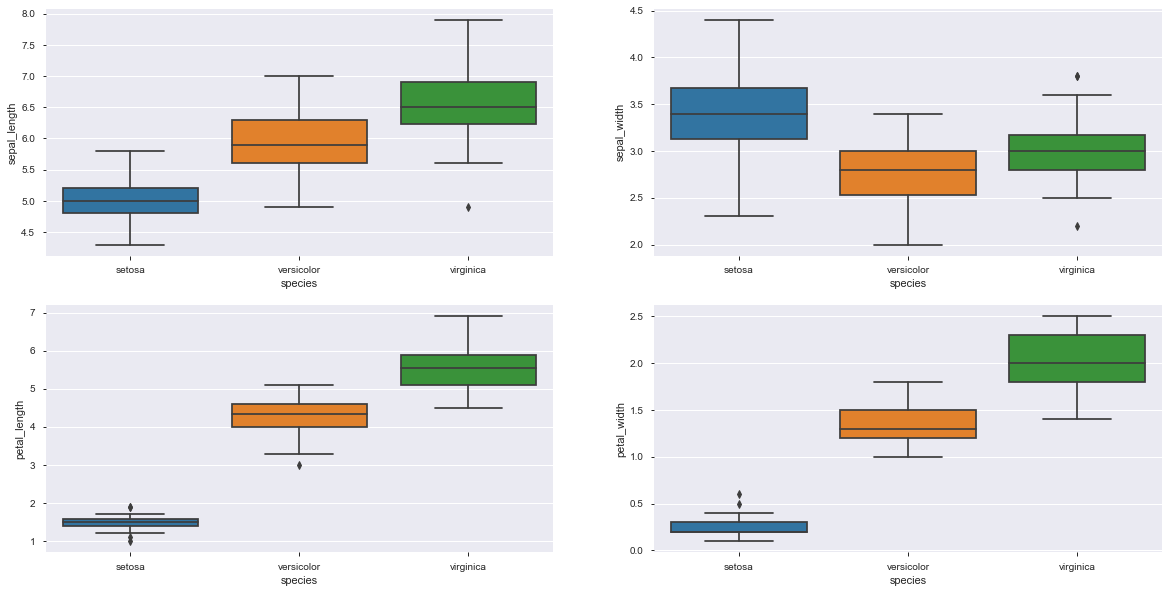

In [5]:
#Boxplot of Features

fig,ax=plt.subplots(nrows=2 ,ncols=2)

sns.boxplot(data=dataset,y='sepal_length',x='species',ax=ax[0,0])
sns.boxplot(data=dataset,y='sepal_width',x='species',ax=ax[0,1])
sns.boxplot(data=dataset,y='petal_length',x='species',ax=ax[1,0])
sns.boxplot(data=dataset,y='petal_width',x='species',ax=ax[1,1])
fig.set_figwidth(20)
fig.set_figheight(10)

Class Split
virginica     50
versicolor    50
setosa        50
Name: species, dtype: int64


Text(0, 0.5, 'Count')

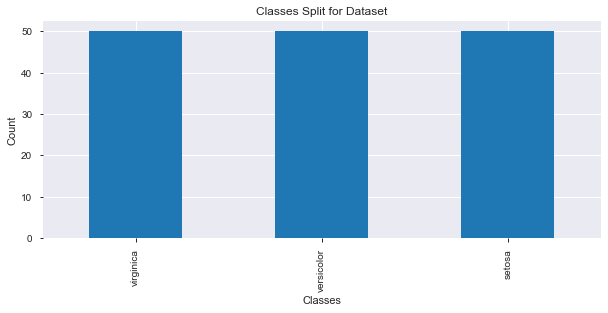

In [6]:
#Class Balance
print('Class Split')
print(dataset['species'].value_counts())
dataset['species'].value_counts().plot.bar(figsize=(10,4),title='Classes Split for Dataset')
plt.xlabel('Classes')
plt.ylabel('Count')

In [7]:
#Create x and y variables
x = dataset.drop('species', axis=1).values
Y = dataset['species'].values

# Train and Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.20,stratify=Y,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.fit_transform(x_test)

x_2 = sc.fit_transform(x)

#Import Model
from sklearn.linear_model import LogisticRegression

In [8]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(multi_class='multinomial',solver='newton-cg',
                                               random_state=100,max_iter=1000))])
pipeline.insert(0,pipe_logreg)

# Set grid search params 

modelpara =[]

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l2'],
                   'clf__solver':['newton-cg', 'sag', 'saga' , 'lbfgs']}
modelpara.insert(0,param_gridlogreg)

Model Evaluation - Accuracy Score
Logistic Regression 0.95 +/- 0.05




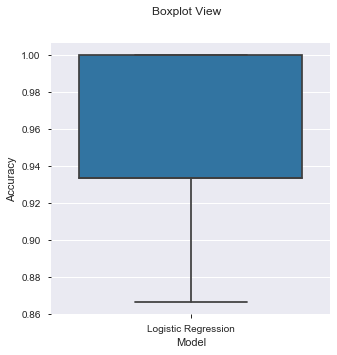

In [9]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Logistic Regression',pipe_logreg))

#Model Evaluation
results =[]
names=[]
scoring ='accuracy'
print('Model Evaluation - Accuracy Score')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x,Y,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

In [10]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, n_jobs=1, cv=cv2,scoring='accuracy')
    gs_clf = gs_clf.fit(x_train2, y_train)
    model = gs_clf.best_estimator_
    
    #Nested CV
    scoreACC = cross_val_score(gs_clf, x_2, Y, 
                             scoring='accuracy', cv=5,
                             n_jobs= -1)
    
    scorePM = cross_val_score(gs_clf, x_2, Y, 
                             scoring='precision_weighted', cv=5,
                             n_jobs= -1)
    
    scoreRM = cross_val_score(gs_clf, x_2, Y, 
                             scoring='recall_weighted', cv=5,
                             n_jobs= -1)
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test2)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    target_names=['setosa','versicolor','virginica']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
    print('\nNestedCV Accuracy(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreACC),np.std(scoreACC)))
    print('NestedCV Precision(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scorePM),np.std(scorePM)))
    print('NestedCV Recall(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreRM),np.std(scoreRM)))
    print('\n')    

In [11]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)


Optimized Model

Model Name: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=100, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

Best Parameters: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}

 [[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]

               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.91      1.00      0.95        10
   virginica       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


NestedCV Accuracy(weighted) :0.97 +/-0.03 
NestedCV Precision(weighted) :0.98 +/-0.03 
NestedCV Recall(weighted) :0.97 +/-0.03 


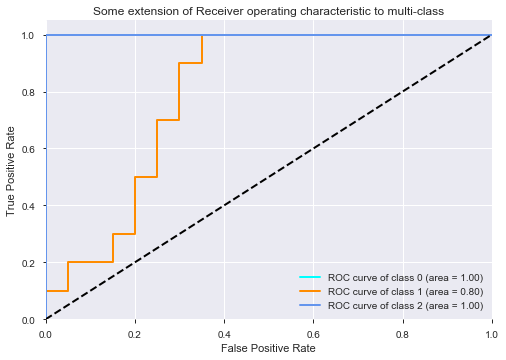

In [12]:
# Creating Multivariable ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle

# Binarize the output
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
le = LabelEncoder()
y2=dataset['species']
y3= le.fit_transform(y2)
y3 = label_binarize(y3, classes=[0, 1, 2])
x2 = dataset.drop('species', axis=1).values

#Creating Training and Testing Data
x_train3, x_test3, y_train3, y_test3 = train_test_split(x2, y3, test_size=0.20,stratify=Y,random_state=100)
n_classes = y3.shape[1]

#Create ROC Curve
from sklearn.multiclass import OneVsRestClassifier
classOrg = model
classifier = OneVsRestClassifier(model)
y_score = classifier.fit(x_train3, y_train3).predict_proba(x_test3)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test3[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  
    
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()    


Using TensorFlow backend.


Logistic Regression

Permutation Importance




Weight,Feature
0.2667 ± 0.1738,petal_width
0.1800 ± 0.0904,petal_length
0.0800 ± 0.0533,sepal_width
0.0333 ± 0.0596,sepal_length


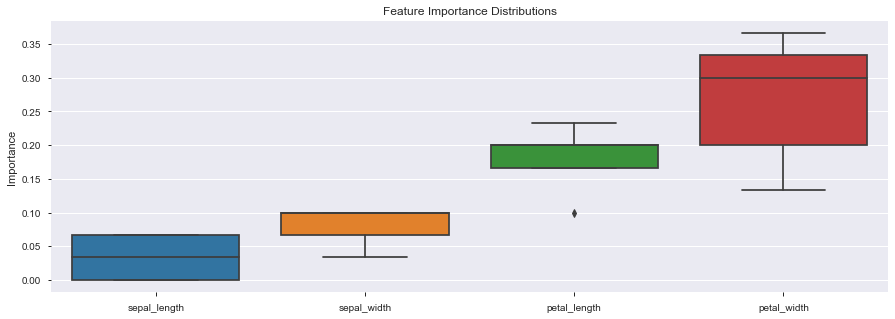

In [13]:
#Next Steps - Feature Importance
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display

for name, model in models:
    print(name)
    perm=PermutationImportance(model.fit(x_train2,y_train),random_state=100).fit(x_test2,y_test)
    features=dataset.drop('species',axis=1).columns
    print('\nPermutation Importance')
    print('\n')
    df=eli5.show_weights(perm,feature_names=dataset.drop('species',axis=1).columns.tolist())
    display(df)
    df2= pd.DataFrame(data=perm.results_,columns=features)
    fig = plt.figure(figsize=(15,5))
    sns.boxplot(data=df2).set(title='Feature Importance Distributions',
                             ylabel='Importance')
    plt.show()

In [14]:
#Next Steps - Feature Selection using SelectFromModel
from sklearn.feature_selection import SelectFromModel
clf = LogisticRegression(multi_class='multinomial',solver='newton-cg',
                                               random_state=100,max_iter=1000)
clf.fit(x_train2,y_train)
model2 = SelectFromModel(clf, prefit=True)
feature_idx = model2.get_support()
feature_name = dataset.drop('species',axis=1).columns[feature_idx]
print('\nKey Features:',feature_name)


Key Features: Index(['petal_length', 'petal_width'], dtype='object')
